# Exploring Word Embeddings

In [23]:
import numpy as np
import pandas as pd
import spacy
import re
import string
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
movies = pd.read_csv('sentiment/movies.csv')
# we will use half of the dataset in order to be able to test more stuff
movies = movies.sample(frac=0.5)
movies

,movie,positive,text
25964,2892,True,Cinderella....<br /><br />I hadn't watched thi...
9679,928,True,"In the ""goofs"" section for this film there's a..."
1863,4415,True,"Although some may call it a ""Cuban Cinema Para..."
43564,1228,False,"I, like many folks, believe the 1989 epic Lone..."
9865,12162,False,"This is not horror, as the first part was: Thi..."
...,...,...,...
48993,10040,False,The filmmaker stayed true to the most accurate...
358,2171,False,This movie surely has one of the strangest the...
46412,3522,True,This noir may not be the best remembered film ...
46641,9315,True,I've heard a lot about Porno Holocaust and its...


## Approach 1: Logistic regression of the Term-Frequency matrix

In [3]:
# define preprocessing to be applied
not_alphanumeric_or_space = re.compile('[^(\w|\s|\d)]')
nlp = spacy.load('en_core_web_sm')

def preprocess(doc):
    doc = re.sub(not_alphanumeric_or_space, '', doc)
    words = [t.lemma_ for t in nlp(doc) if t.lemma_ != '-PRON-']
    return ' '.join(words).lower()

In [4]:
# define the vectorizer
vect = TfidfVectorizer(min_df=2,
                         max_df=.8,
                         preprocessor=preprocess,
                         stop_words='english',
                         use_idf=False,
                         norm=False)

In [5]:
# learn the vocabulary from the whole dataset
vect.fit(movies.text)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=None,
                min_df=2, ngram_range=(1, 1), norm=False,
                preprocessor=<function preprocess at 0x7f57912e05f0>,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=False, vocabulary=None)

In [6]:
def test_ratio(docs, target, vectorizer, model, test_size):
    """ function to generate features from a vectorizer and test 
        the accuracy of a prediction model by performing a train/test split
        
        Returns: accuracy score on the test dataset
    """
    
    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(docs, 
                                                        target, 
                                                        test_size= test_size)
    
    # fit the vectorizer to the train dataset and get the TF matrix
    features_train = vectorizer.transform(X_train)
    features_train = features_train.todense()

    # fit the same vectorizer to the test set
    features_test = vectorizer.transform(X_test)
    features_test = features_test.todense()
    
    # fit the logistic regression
    fitted_model = model.fit(features_train, y_train)
    
    # use the fitted model for prediction
    y_pred = model.predict(features_test)
    
    return(accuracy_score(y_pred, y_test))

In [137]:
# define the model
LR = LogisticRegression(solver='lbfgs', n_jobs = -1)

In [138]:
# several ratios between test/train 
ratios = [r/100 for r in list(range(50,99,5))]
ratios.extend([0.975, 0.99])

accuracies = []
for ratio in ratios:
    print("Checking ratio: ", ratio)
    accuracies.append(test_ratio(movies.text, movies.positive, vect, LR, ratio))

Checking ratio:  0.975
Checking ratio:  0.99


In [9]:
# save results in a dictionary
results = dict()
results['TF'] = accuracies

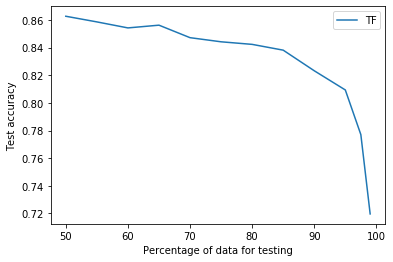

In [232]:
ratios = [r*100 for r in ratios]
plt.plot(ratios, results['TF'], label = 'TF')
plt.ylabel('Test accuracy')
plt.xlabel('Percentage of data for testing')
plt.legend()
plt.show()

## Approach 2:

In [12]:
# https://radimrehurek.com/gensim/models/word2vec.html
import gensim.models

In [13]:
# simple text cleanning for Word2Vec
def embeddings_preprocess(docs):
    """ function to apply basic text cleaning processes to
        a list of documents
        
        Returns: a list of documents represented as lists of words
    """
    
    
    #remove all HTML tags
    cleaner_exp = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    docs_clean = [re.sub(cleaner_exp, '', doc) for doc in docs]
    
    #Convert all docs to lowercase
    docs_lc = [doc.lower() for doc in docs_clean]

    #Delete all punctuation
    docs_lc = [doc.translate(str.maketrans('', '', string.punctuation)) for doc in docs_lc]

    #Delete all digits
    docs_lc = [re.sub('\d', '', doc) for doc in docs_lc]
    
    #Represent docs as lists of words
    docs_words = [doc.split() for doc in docs_lc]

    return(docs_words)

In [14]:
clean_docs = embeddings_preprocess(movies.text)

In [16]:
# get a feel for the cleanning
i = np.random.randint(0, len(movies))
print(movies.iloc[i,2])
print("\n ------------------------------------------------------- \n")
print(clean_docs[i])

This adaption contains two parts: <br /><br />1. The "now" time, when Gulliver is at home in England and soon is put into a mental asylum by the Evil Dr. Bates <br /><br />2. The "described" time, in which Gulliver describes his travels.<br /><br />The times are interspersed with a very choppy tempo, which makes willing suspense of disbelief far more difficult than it would have been if the movie simply would have discarded that part, and followed the book as written. In the book, there is no Dr. Bates, no asylum, and Mrs Gulliver gets very little mention. The travels - in plural - are depicted as one in the movie. There are several movies covering the topic of sane people dumped into asylum by some nasty person out there, look at them if you want that stuff. The "now" time part adds absolutely nothing to the story's value, is a complete invention by the movie adapters, and takes valuable time from the real story. All the time when this was going on I was longing for the next bit of re

### 2.1. First Word2Vec

- Embeddings size = 100
- Window size = 5
- Skipgram
- K-Negative = 5

In [175]:
model = gensim.models.Word2Vec(size=100, 
                               alpha=0.025, 
                               window=5, 
                               min_count=5, 
                               sample=0.001, 
                               workers=-1, 
                               min_alpha=0.0001, 
                               sg=1, # Training algorithm: 1 for skip-gram; otherwise CBOW
                               hs=0, # If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
                               negative=5, # K-negative
                               ns_exponent=0.75,
                               cbow_mean=1, 
                               iter=5, 
                               null_word=0, 
                               trim_rule=None, 
                               sorted_vocab=1, 
                               batch_words=10000, 
                               compute_loss=False, 
                               callbacks=(), 
                               max_final_vocab=None)

In [176]:
# 1. build the vocabulary
model.build_vocab(clean_docs)

In [177]:
# 2. train the model
model.train(clean_docs,
            total_examples=model.corpus_count,
            epochs=100)

(0, 0)

In [178]:
model.wv.vocab

{'hadnt': <gensim.models.keyedvectors.Vocab at 0x7f56a66a4b50>,
 'watched': <gensim.models.keyedvectors.Vocab at 0x7f56a66bc190>,
 'this': <gensim.models.keyedvectors.Vocab at 0x7f56a66bc0d0>,
 'film': <gensim.models.keyedvectors.Vocab at 0x7f56a66bc390>,
 'for': <gensim.models.keyedvectors.Vocab at 0x7f576ddce110>,
 'about': <gensim.models.keyedvectors.Vocab at 0x7f56a786e0d0>,
 'five': <gensim.models.keyedvectors.Vocab at 0x7f576e0f8e90>,
 'years': <gensim.models.keyedvectors.Vocab at 0x7f576e0ee390>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7f56a66bc4d0>,
 'last': <gensim.models.keyedvectors.Vocab at 0x7f576ddce5d0>,
 'time': <gensim.models.keyedvectors.Vocab at 0x7f576e0ee250>,
 'i': <gensim.models.keyedvectors.Vocab at 0x7f56a6c85cd0>,
 'saw': <gensim.models.keyedvectors.Vocab at 0x7f56a6c85590>,
 'it': <gensim.models.keyedvectors.Vocab at 0x7f56a6c85710>,
 'magic': <gensim.models.keyedvectors.Vocab at 0x7f56a6c85150>,
 'remains': <gensim.models.keyedvectors.Vocab at 0x7f56a

In [179]:
# verify that the vectors were generated
model.wv['magic']

array([ 2.8986027e-03,  2.1082121e-03,  1.5148193e-04,  4.3296888e-05,
       -4.4184043e-03,  2.5216320e-03, -3.4976865e-03,  3.3197973e-03,
        1.7647870e-03, -2.5020444e-03,  1.6759604e-04, -1.3123845e-03,
        4.4903485e-03,  4.4367020e-03, -1.9141821e-03, -7.3217860e-05,
       -1.6462028e-03,  1.9160608e-03, -4.6922485e-03,  1.3362458e-03,
        2.9599946e-03, -2.7373347e-03,  8.3163375e-04,  1.4450579e-03,
        2.3328813e-03, -3.8155417e-03,  1.0429492e-03,  3.7059062e-03,
        4.0055062e-03,  3.3480306e-03, -2.7161042e-05, -2.9049374e-03,
        2.9182704e-03,  4.8301592e-03,  1.0484622e-03,  4.2339563e-03,
       -2.1314891e-03, -3.2422424e-04, -6.4992043e-04, -7.6996896e-04,
        1.1759076e-03, -4.7687874e-03,  2.2611857e-04,  9.0573571e-04,
        1.7827615e-03, -1.8495582e-04,  4.2204293e-03,  1.2676386e-03,
       -1.9660299e-03, -3.8083522e-03, -3.3759198e-03, -8.9462024e-05,
       -4.6300194e-03,  8.8255137e-04,  1.8778564e-03, -1.9070068e-03,
      

In [180]:
# 3. represent the corpus using the word embeddings
def docs2embs(model,docs):
    """ function to a list of documents into their word embeddings 
        representation; each document is a list of vectors
    """
    # empty list to store the results
    docs_emb = []
    
    # keep a counter on the number of words that where note embedded
    not_embedded = 0
    all_words = 0
    for idx,doc in enumerate(docs):
        # create empty lists to represent each document in the corpus
        docs_emb.append([])
        for word in doc:
            try:
                docs_emb[idx].append(model.wv[word])
                all_words +=1
            except:
                not_embedded +=1
                all_words +=1
    
    print("Warning: ", not_embedded, " out of ", all_words , " could not be embedded")
    
    return(docs_emb)

In [181]:
docs_emb = docs2embs(model,clean_docs)

In [182]:
# check lengths
len(docs_emb), len(movies)

(25002, 25002)

In [183]:
# 4. use the word embeddings to generate a representation of the document
def doc_embedding_sum(docs_emb):
    """ function to transform a list of documents represented by their
        word embeddings into an aggregate representation of each document
        obtained by summing the word embedings and normalizing
    """
    
    # empty list to store results
    docs_agg = []
    
    for doc in docs_emb:
        # sum all elements from the same dimension for all words
        agg_emb = np.sum(doc, axis = 0)
        # normalize
        agg_emb_norm = agg_emb/np.linalg.norm(agg_emb) 
        docs_agg.append(agg_emb_norm)

    
    return(docs_agg)

In [184]:
docs_final = doc_embedding_sum(docs_emb)

In [185]:
# 5. test performance!
def test_ratio2(docs, target, model, test_size):
    """ function to test the accuracy of a model by performing
        a train/test split
    """
    
    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(docs, 
                                                        target, 
                                                        test_size= test_size)
    
    # fit the logistic regression
    fitted_model = model.fit(X_train, y_train)
    
    # use the fitted model for prediction
    y_pred = model.predict(X_test)
    
    return(accuracy_score(y_pred, y_test))

In [186]:
# define the classification model
LR = LogisticRegression(solver='lbfgs', n_jobs = -1)

# several ratios between test/train 
ratios = [r/100 for r in list(range(50,99,5))]
ratios.extend([0.975, 0.99])

accuracies = []
for ratio in ratios:
    print("\n***** Testing ratio: ", ratio)
    accuracies.append(test_ratio2(docs_final, movies.positive, LR, ratio))


***** Testing ratio:  0.5

***** Testing ratio:  0.55

***** Testing ratio:  0.6

***** Testing ratio:  0.65

***** Testing ratio:  0.7

***** Testing ratio:  0.75

***** Testing ratio:  0.8

***** Testing ratio:  0.85

***** Testing ratio:  0.9

***** Testing ratio:  0.95

***** Testing ratio:  0.975

***** Testing ratio:  0.99


In [187]:
results['word2vec_1'] = accuracies

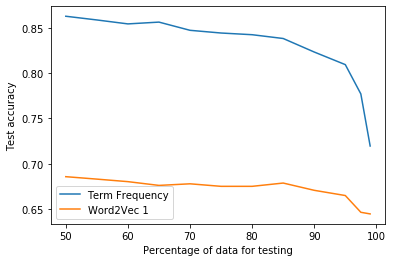

In [233]:
ratios = [r*100 for r in ratios]
plt.plot(ratios, results['TF'], label='Term Frequency')
plt.plot(ratios, results['word2vec_1'], label='Word2Vec 1')
plt.ylabel('Test accuracy')
plt.xlabel('Percentage of data for testing')
plt.legend()
plt.show()

### 2.2. Second Word2Vec - Bag of Words

- Embeddings size = 100
- Window size = 5
- BOW
- K-Negative = 5

In [189]:
model2 = gensim.models.Word2Vec(size=100, 
                               alpha=0.025, 
                               window=5, 
                               min_count=5, 
                               sample=0.001, 
                               workers=-1, 
                               min_alpha=0.0001, 
                               sg=0, # Training algorithm: 1 for skip-gram; otherwise CBOW
                               hs=0, # If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
                               negative=5, # K-negative
                               ns_exponent=0.75,
                               cbow_mean=1, 
                               iter=5, 
                               null_word=0, 
                               trim_rule=None, 
                               sorted_vocab=1, 
                               batch_words=10000, 
                               compute_loss=False, 
                               callbacks=(), 
                               max_final_vocab=None)

In [190]:
# 1. build the vocabulary
model2.build_vocab(clean_docs)

In [191]:
# 2. train the model
model2.train(clean_docs,
            total_examples=model2.corpus_count,
            epochs=100)

(0, 0)

In [192]:
# 3. represent the corpus using the word embeddings
docs_emb = docs2embs(model2,clean_docs)

In [193]:
# 4. use the word embeddings to generate a representation of the document
docs_final = doc_embedding_sum(docs_emb)

In [194]:
# 5. test performance!
LR = LogisticRegression(solver='lbfgs', n_jobs = -1)

ratios = [r/100 for r in list(range(50,99,5))]
ratios.extend([0.975, 0.99])

accuracies = []
for ratio in ratios:
    print("\n***** Testing ratio: ", ratio)
    accuracies.append(test_ratio2(docs_final, movies.positive, LR, ratio))


***** Testing ratio:  0.5

***** Testing ratio:  0.55

***** Testing ratio:  0.6

***** Testing ratio:  0.65

***** Testing ratio:  0.7

***** Testing ratio:  0.75

***** Testing ratio:  0.8

***** Testing ratio:  0.85

***** Testing ratio:  0.9

***** Testing ratio:  0.95

***** Testing ratio:  0.975

***** Testing ratio:  0.99


In [195]:
results['word2vec_2'] = accuracies

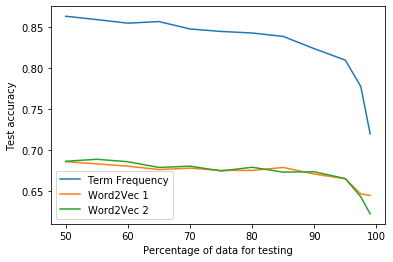

In [234]:
ratios = [r*100 for r in ratios]
plt.plot(ratios, results['TF'], label='Term Frequency')
plt.plot(ratios, results['word2vec_1'], label='Word2Vec 1')
plt.plot(ratios, results['word2vec_2'], label='Word2Vec 2')
plt.ylabel('Test accuracy')
plt.xlabel('Percentage of data for testing')
plt.legend()
plt.show()

### 2.3. Third Word2Vec 

- Embeddings size = 100
- Window size = 20
- BOW
- K-Negative = 5

In [197]:
model3 = gensim.models.Word2Vec(size=100, 
                               alpha=0.025, 
                               window=20, 
                               min_count=5, 
                               sample=0.001, 
                               workers=-1, 
                               min_alpha=0.0001, 
                               sg=0, # Training algorithm: 1 for skip-gram; otherwise CBOW
                               hs=0, # If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
                               negative=5, # K-negative
                               ns_exponent=0.75,
                               cbow_mean=1, 
                               iter=5, 
                               null_word=0, 
                               trim_rule=None, 
                               sorted_vocab=1, 
                               batch_words=10000, 
                               compute_loss=False, 
                               callbacks=(), 
                               max_final_vocab=None)

In [198]:
# 1. build the vocabulary
model3.build_vocab(clean_docs)

In [199]:
# 2. train the model
model3.train(clean_docs,
            total_examples=model3.corpus_count,
            epochs=100)

(0, 0)

In [200]:
# 3. represent the corpus using the word embeddings
docs_emb = docs2embs(model3,clean_docs)

In [201]:
# 4. use the word embeddings to generate a representation of the document
docs_final = doc_embedding_sum(docs_emb)

In [202]:
# 5. test performance!
LR = LogisticRegression(solver='lbfgs', n_jobs = -1)

ratios = [r/100 for r in list(range(50,99,5))]
ratios.extend([0.975, 0.99])

accuracies = []
for ratio in ratios:
    print("\n***** Testing ratio: ", ratio)
    accuracies.append(test_ratio2(docs_final, movies.positive, LR, ratio))


***** Testing ratio:  0.5

***** Testing ratio:  0.55

***** Testing ratio:  0.6

***** Testing ratio:  0.65

***** Testing ratio:  0.7

***** Testing ratio:  0.75

***** Testing ratio:  0.8

***** Testing ratio:  0.85

***** Testing ratio:  0.9

***** Testing ratio:  0.95

***** Testing ratio:  0.975

***** Testing ratio:  0.99


In [203]:
results['word2vec_3'] = accuracies

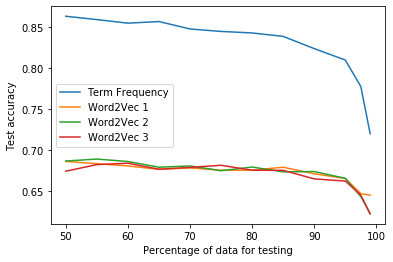

In [235]:
ratios = [r*100 for r in ratios]
plt.plot(ratios, results['TF'], label='Term Frequency')
plt.plot(ratios, results['word2vec_1'], label='Word2Vec 1')
plt.plot(ratios, results['word2vec_2'], label='Word2Vec 2')
plt.plot(ratios, results['word2vec_3'], label='Word2Vec 3')
plt.ylabel('Test accuracy')
plt.xlabel('Percentage of data for testing')
plt.legend()
plt.show()

### 2.4. Fourth Word2Vec 

- Embeddings size = 100
- Window size = 20
- BOW
- K-Negative = 20

In [205]:
model4 = gensim.models.Word2Vec(size=100, 
                               alpha=0.025, 
                               window=20, 
                               min_count=5, 
                               sample=0.001, 
                               workers=-1, 
                               min_alpha=0.0001, 
                               sg=0, # Training algorithm: 1 for skip-gram; otherwise CBOW
                               hs=0, # If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
                               negative=20, # K-negative
                               ns_exponent=0.75,
                               cbow_mean=1, 
                               iter=5, 
                               null_word=0, 
                               trim_rule=None, 
                               sorted_vocab=1, 
                               batch_words=10000, 
                               compute_loss=False, 
                               callbacks=(), 
                               max_final_vocab=None)

In [206]:
# 1. build the vocabulary
model4.build_vocab(clean_docs)

In [207]:
# 2. train the model
model4.train(clean_docs,
            total_examples=model4.corpus_count,
            epochs=100)

(0, 0)

In [208]:
# 3. represent the corpus using the word embeddings
docs_emb = docs2embs(model4,clean_docs)

In [209]:
# 4. use the word embeddings to generate a representation of the document
docs_final = doc_embedding_sum(docs_emb)

In [210]:
# 5. test performance!
LR = LogisticRegression(solver='lbfgs', n_jobs = -1)

ratios = [r/100 for r in list(range(50,99,5))]
ratios.extend([0.975, 0.99])

accuracies = []
for ratio in ratios:
    print("\n*****Testing ratio: ", ratio)
    accuracies.append(test_ratio2(docs_final, movies.positive, LR, ratio))


*****Testing ratio:  0.5

*****Testing ratio:  0.55

*****Testing ratio:  0.6

*****Testing ratio:  0.65

*****Testing ratio:  0.7

*****Testing ratio:  0.75

*****Testing ratio:  0.8

*****Testing ratio:  0.85

*****Testing ratio:  0.9

*****Testing ratio:  0.95

*****Testing ratio:  0.975

*****Testing ratio:  0.99


In [211]:
results['word2vec_4'] = accuracies

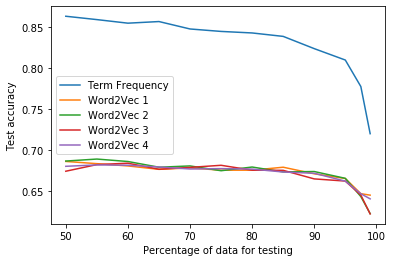

In [236]:
ratios = [r*100 for r in ratios]
plt.plot(ratios, results['TF'], label='Term Frequency')
plt.plot(ratios, results['word2vec_1'], label='Word2Vec 1')
plt.plot(ratios, results['word2vec_2'], label='Word2Vec 2')
plt.plot(ratios, results['word2vec_3'], label='Word2Vec 3')
plt.plot(ratios, results['word2vec_4'], label='Word2Vec 4')
plt.ylabel('Test accuracy')
plt.xlabel('Percentage of data for testing')
plt.legend()
plt.show()

### 2.5. Fifth Word2Vec: is it all about the size? 

- Embeddings size = 300
- Window size = 20
- BOW
- K-Negative = 20

In [213]:
model5 = gensim.models.Word2Vec(size=300, 
                               alpha=0.025, 
                               window=20, 
                               min_count=5, 
                               sample=0.001, 
                               workers=-1, 
                               min_alpha=0.0001, 
                               sg=0, # Training algorithm: 1 for skip-gram; otherwise CBOW
                               hs=0, # If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
                               negative=20, # K-negative
                               ns_exponent=0.75,
                               cbow_mean=1, 
                               iter=5, 
                               null_word=0, 
                               trim_rule=None, 
                               sorted_vocab=1, 
                               batch_words=10000, 
                               compute_loss=False, 
                               callbacks=(), 
                               max_final_vocab=None)

In [214]:
# 1. build the vocabulary
model5.build_vocab(clean_docs)

In [215]:
# 2. train the model
model5.train(clean_docs,
            total_examples=model5.corpus_count,
            epochs=100)

(0, 0)

In [216]:
# 3. represent the corpus using the word embeddings
docs_emb = docs2embs(model5,clean_docs)

In [217]:
# 4. use the word embeddings to generate a representation of the document
docs_final = doc_embedding_sum(docs_emb)

In [218]:
# 5. test performance!
LR = LogisticRegression(solver='lbfgs', n_jobs = -1)

ratios = [r/100 for r in list(range(50,99,5))]
ratios.extend([0.975, 0.99])

accuracies = []
for ratio in ratios:
    print("\n***** Testing ratio: ", ratio)
    accuracies.append(test_ratio2(docs_final, movies.positive, LR, ratio))


***** Testing ratio:  0.5

***** Testing ratio:  0.55

***** Testing ratio:  0.6

***** Testing ratio:  0.65

***** Testing ratio:  0.7

***** Testing ratio:  0.75

***** Testing ratio:  0.8

***** Testing ratio:  0.85

***** Testing ratio:  0.9

***** Testing ratio:  0.95

***** Testing ratio:  0.975

***** Testing ratio:  0.99


In [219]:
results['word2vec_5'] = accuracies

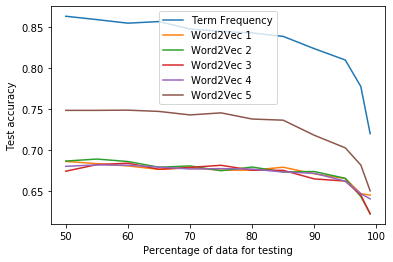

In [237]:
ratios = [r*100 for r in ratios]
plt.plot(ratios, results['TF'], label='Term Frequency')
plt.plot(ratios, results['word2vec_1'], label='Word2Vec 1')
plt.plot(ratios, results['word2vec_2'], label='Word2Vec 2')
plt.plot(ratios, results['word2vec_3'], label='Word2Vec 3')
plt.plot(ratios, results['word2vec_4'], label='Word2Vec 4')
plt.plot(ratios, results['word2vec_5'], label='Word2Vec 5')
plt.ylabel('Test accuracy')
plt.xlabel('Percentage of data for testing')
plt.legend()
plt.show()

### 2.6. Sixth Word2Vec 

- Embeddings size = 300
- Window size = 5
- BOW
- K-Negative = 5


In [221]:
model6 = gensim.models.Word2Vec(size=300, 
                               alpha=0.025, 
                               window=5, 
                               min_count=3, 
                               sample=0.001, 
                               workers=-1, 
                               min_alpha=0.0001, 
                               sg=0, # Training algorithm: 1 for skip-gram; otherwise CBOW
                               hs=1, # If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
                               negative=5, # K-negative
                               ns_exponent=0.75,
                               cbow_mean=1, 
                               iter=20, 
                               null_word=0, 
                               trim_rule=None, 
                               sorted_vocab=1, 
                               batch_words=10000, 
                               compute_loss=False, 
                               callbacks=(), 
                               max_final_vocab=None)

In [222]:
# 1. build the vocabulary
model6.build_vocab(clean_docs)

In [223]:
# 2. train the model
model6.train(clean_docs,
            total_examples=model6.corpus_count,
            epochs=100)

(0, 0)

In [224]:
# 3. represent the corpus using the word embeddings
docs_emb = docs2embs(model6,clean_docs)

In [225]:
# 4. use the word embeddings to generate a representation of the document
docs_final = doc_embedding_sum(docs_emb)

In [226]:
# 5. test performance!
LR = LogisticRegression(solver='lbfgs', n_jobs = -1)

ratios = [r/100 for r in list(range(50,99,5))]
ratios.extend([0.975, 0.99])

accuracies = []
for ratio in ratios:
    print("\n***** Testing ratio: ", ratio)
    accuracies.append(test_ratio2(docs_final, movies.positive, LR, ratio))


***** Testing ratio:  0.5

***** Testing ratio:  0.55

***** Testing ratio:  0.6

***** Testing ratio:  0.65

***** Testing ratio:  0.7

***** Testing ratio:  0.75

***** Testing ratio:  0.8

***** Testing ratio:  0.85

***** Testing ratio:  0.9

***** Testing ratio:  0.95

***** Testing ratio:  0.975

***** Testing ratio:  0.99


In [227]:
results['word2vec_6'] = accuracies

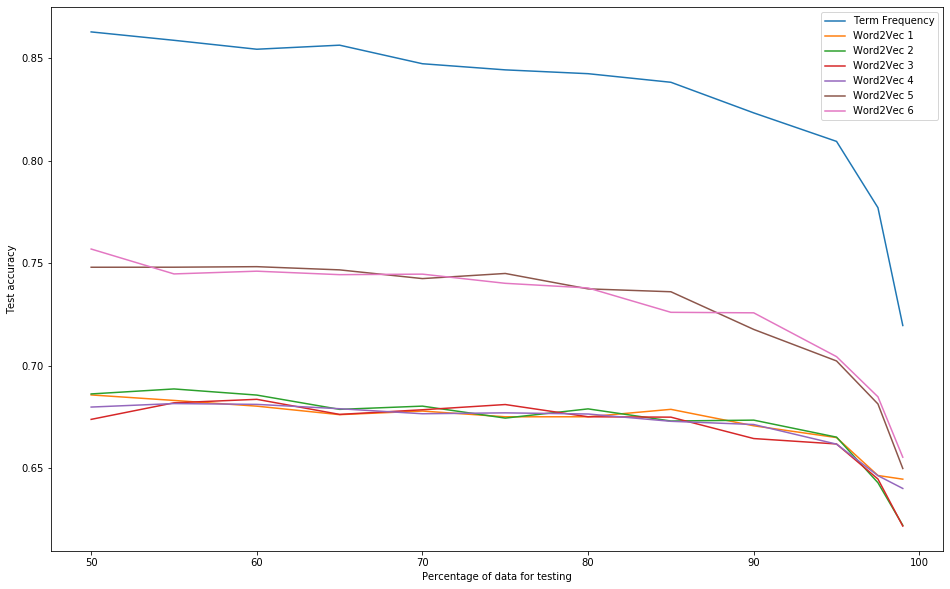

In [242]:
#ratios = [r*100 for r in ratios]
plt.figure(figsize=(16,10))

plt.plot(ratios, results['TF'], label='Term Frequency')
plt.plot(ratios, results['word2vec_1'], label='Word2Vec 1')
plt.plot(ratios, results['word2vec_2'], label='Word2Vec 2')
plt.plot(ratios, results['word2vec_3'], label='Word2Vec 3')
plt.plot(ratios, results['word2vec_4'], label='Word2Vec 4')
plt.plot(ratios, results['word2vec_5'], label='Word2Vec 5')
plt.plot(ratios, results['word2vec_6'], label='Word2Vec 6')
plt.ylabel('Test accuracy')
plt.xlabel('Percentage of data for testing')
plt.legend()
plt.show()

## Some conclusions

- The term-frequency matrix learned on the whole dataset seems to outperform all of the word embeddings approaches tried. This could potentially be due to the fact that we only used half of the dataset; word embeddings might require to be trainned on more data to "show their true potential".

- It is interesting to see that although the performance (measured by the accuracy in the test data) decreases as the percentage of data used for testing increases, this relationship is very non-linear. The decrease does not seem to be very significant when going from 50% to approximately 90%, but when we reach that point the decrease is very sharp.

- It is also worth noting that the decrease in performance seems to be specially sharp for the approach that uses the term-frequency matrix

In [243]:
with open('results.json', 'w') as fp:
    json.dump(results, fp)